In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import accuracy_score

Data Collection

In [1]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='KD5rIopofqm3dtjUkGx5iZE_mWccNLYjTBG7bLInHs0b',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu-gb.cloud-object-storage.appdomain.cloud')

bucket = 'anvi-donotdelete-pr-y92sqkugmf2o8b'
object_key = 'collegePlace (2).csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()



,Age,Gender,Stream,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
0,22,Male,Electronics And Communication,1,8,1,1,1
1,21,Female,Computer Science,0,7,1,1,1
2,22,Female,Information Technology,1,6,0,0,1
3,21,Male,Information Technology,0,8,0,1,1
4,22,Male,Mechanical,0,8,1,0,1


In [ ]:
df.shape

(2966, 8)

Data Visualization

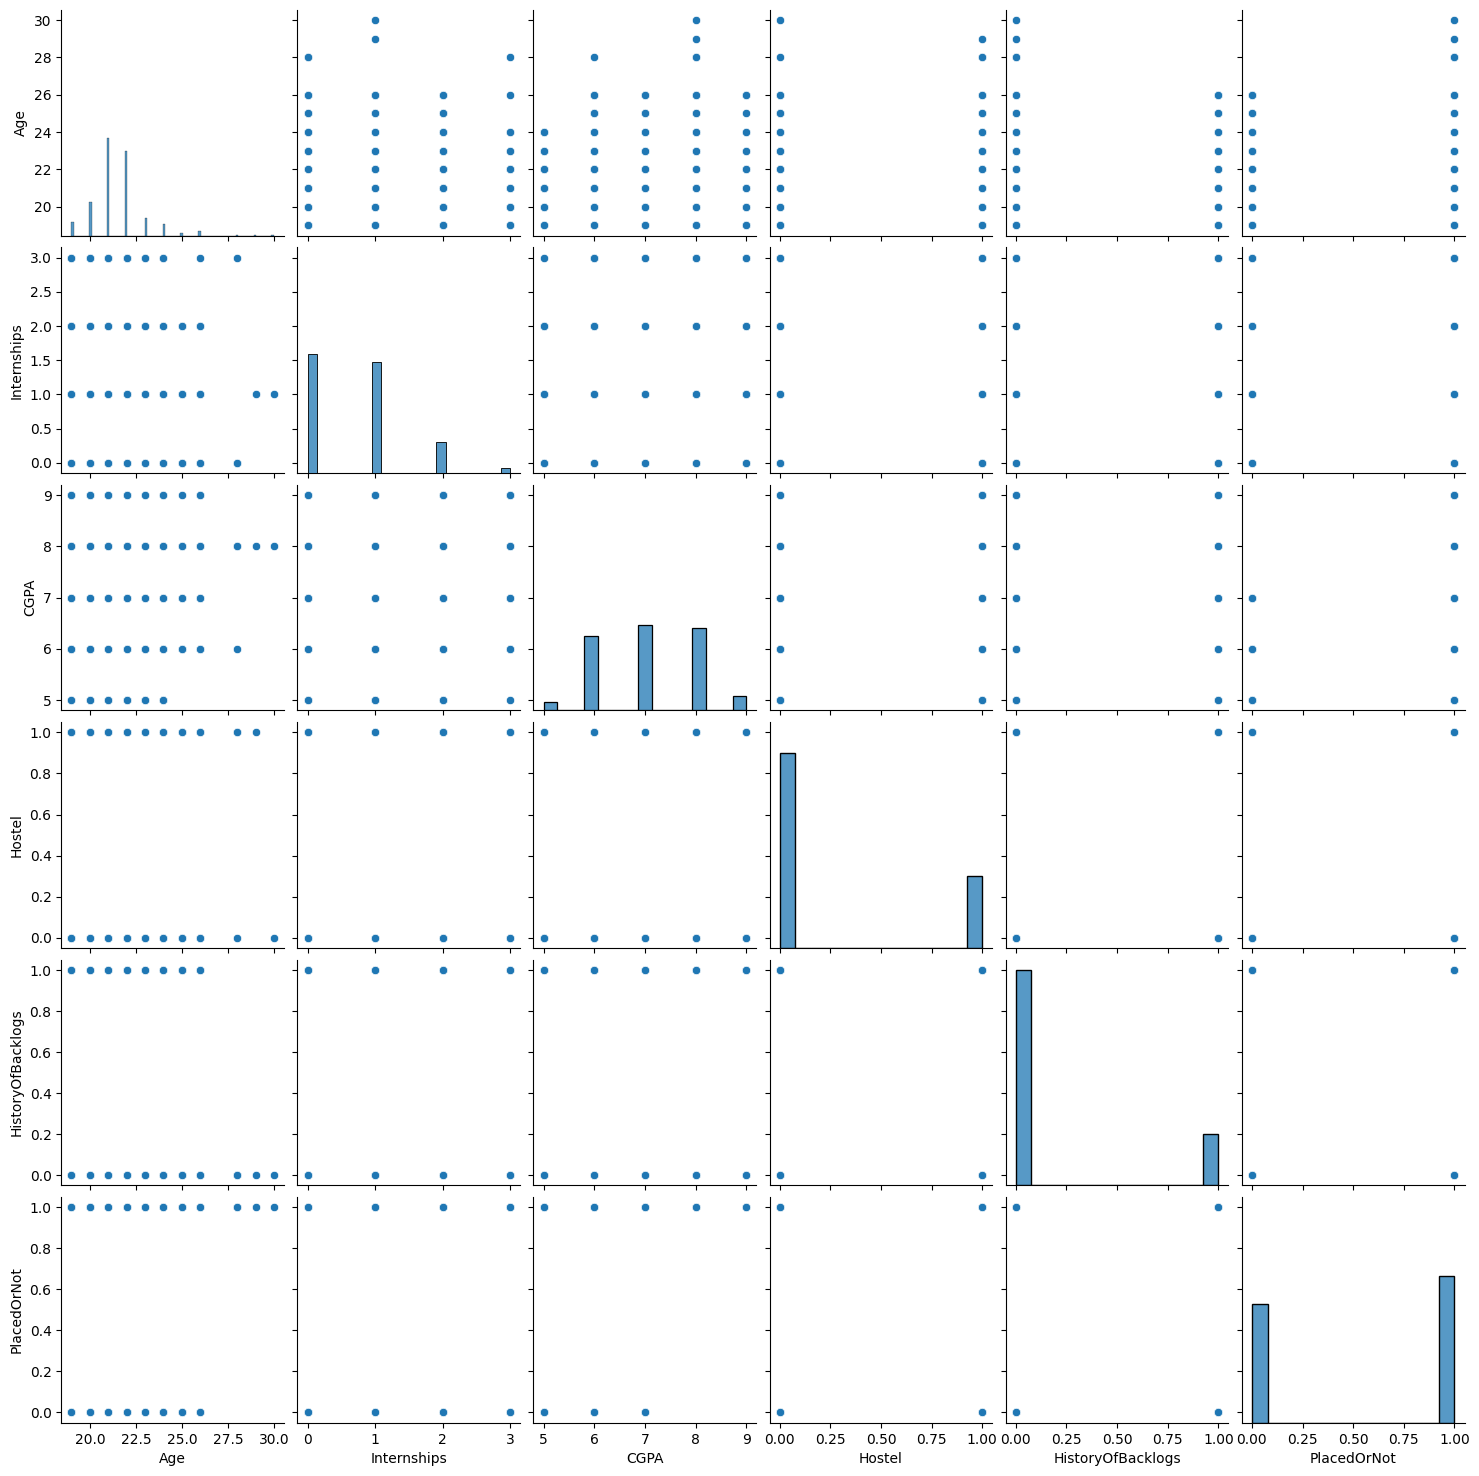

In [ ]:
sns.pairplot(df)

In [ ]:
corr = df.corr()

<ipython-input-38-45893e33df67>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


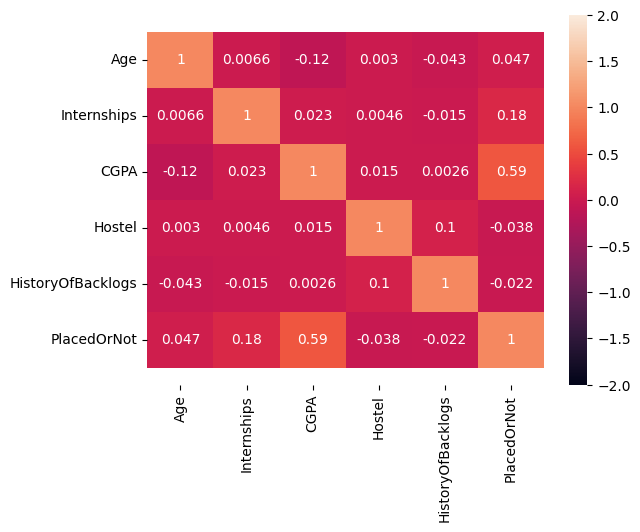

,Age,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
Age,1.000000,0.006552,-0.119787,0.003042,-0.042586,0.046943
Internships,0.006552,1.000000,0.023496,0.004617,-0.015118,0.179334
CGPA,-0.119787,0.023496,1.000000,0.014991,0.002576,0.588648
Hostel,0.003042,0.004617,0.014991,1.000000,0.103506,-0.038182
HistoryOfBacklogs,-0.042586,-0.015118,0.002576,0.103506,1.000000,-0.022337
PlacedOrNot,0.046943,0.179334,0.588648,-0.038182,-0.022337,1.000000


In [ ]:
ax = sns.heatmap(corr, vmin = -2, vmax = 2, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.3, top - 0.3)
plt.show()
corr

<ipython-input-41-f92659182652>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['CGPA'],color='r')


<Axes: xlabel='CGPA', ylabel='Density'>

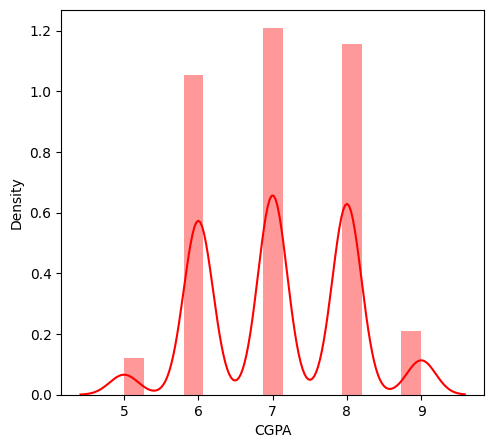

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.distplot(df['CGPA'],color='b')

<ipython-input-42-5e468beb8a0d>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['PlacedOrNot'],color='r')


<Axes: xlabel='PlacedOrNot', ylabel='Density'>

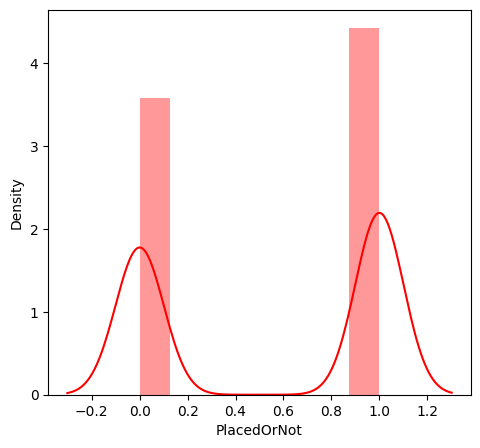

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.distplot(df['PlacedOrNot'],color='r')

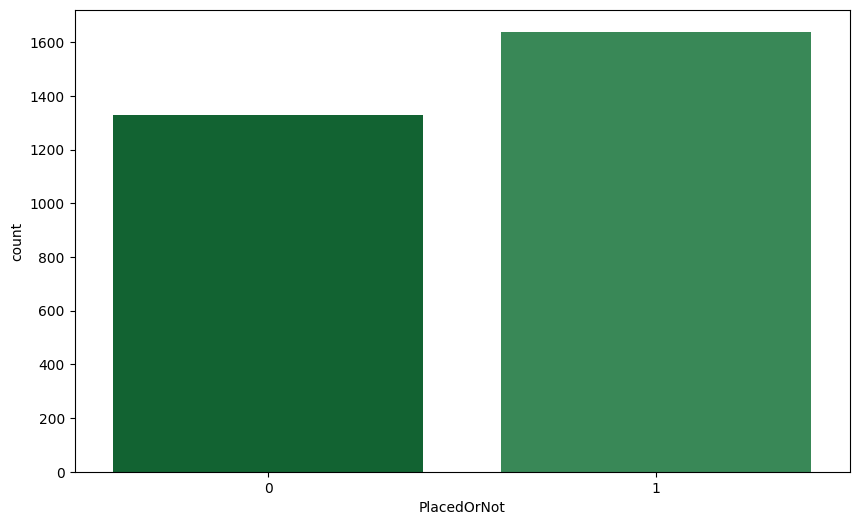

In [ ]:
# how many placed ?
plt.figure(figsize = (10, 6), dpi = 100)


# setting the different color palette
color_palette = sns.color_palette("BuGn_r")
sns.set_palette(color_palette)

sns.countplot(x = "PlacedOrNot", data = df)

plt.show()

#as we can see data is not that imbalanced

Data Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966 entries, 0 to 2965
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                2966 non-null   int64 
 1   Gender             2966 non-null   object
 2   Stream             2966 non-null   object
 3   Internships        2966 non-null   int64 
 4   CGPA               2966 non-null   int64 
 5   Hostel             2966 non-null   int64 
 6   HistoryOfBacklogs  2966 non-null   int64 
 7   PlacedOrNot        2966 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 185.5+ KB


In [ ]:
df.isnull().sum()

Age                  0
Gender               0
Stream               0
Internships          0
CGPA                 0
Hostel               0
HistoryOfBacklogs    0
PlacedOrNot          0
dtype: int64

In [ ]:
df.describe()

,Age,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
count,2966.000000,2966.000000,2966.000000,2966.000000,2966.000000,2966.000000
mean,21.485840,0.703641,7.073837,0.269049,0.192178,0.552596
std,1.324933,0.740197,0.967748,0.443540,0.394079,0.497310
min,19.000000,0.000000,5.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,6.000000,0.000000,0.000000,0.000000
50%,21.000000,1.000000,7.000000,0.000000,0.000000,1.000000
75%,22.000000,1.000000,8.000000,1.000000,0.000000,1.000000
max,30.000000,3.000000,9.000000,1.000000,1.000000,1.000000


In [ ]:
df['Gender'].value_counts()

Male      2475
Female     491
Name: Gender, dtype: int64

In [ ]:
df['Stream'].value_counts()

Computer Science                 776
Information Technology           691
Electronics And Communication    424
Mechanical                       424
Electrical                       334
Civil                            317
Name: Stream, dtype: int64

In [ ]:
df = df.replace(['Male'], [0])
df = df.replace(['Female'], [1])

In [ ]:
df = df.replace(['Computer Science', 'Information Technology','Electronics And Communication','Mechanical','Electrical','Civil'],
                     [0,1,2,3,4,5])

In [ ]:
df

,Age,Gender,Stream,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
0,22,0,2,1,8,1,1,1
1,21,1,0,0,7,1,1,1
2,22,1,1,1,6,0,0,1
3,21,0,1,0,8,0,1,1
4,22,0,3,0,8,1,0,1
...,...,...,...,...,...,...,...,...
2961,23,0,1,0,7,0,0,0
2962,23,0,3,1,7,1,0,0
2963,22,0,1,1,7,0,0,0
2964,22,0,0,1,7,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966 entries, 0 to 2965
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Age                2966 non-null   int64
 1   Gender             2966 non-null   int64
 2   Stream             2966 non-null   int64
 3   Internships        2966 non-null   int64
 4   CGPA               2966 non-null   int64
 5   Hostel             2966 non-null   int64
 6   HistoryOfBacklogs  2966 non-null   int64
 7   PlacedOrNot        2966 non-null   int64
dtypes: int64(8)
memory usage: 185.5 KB


<ipython-input-59-c0a52fd22336>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(feature)


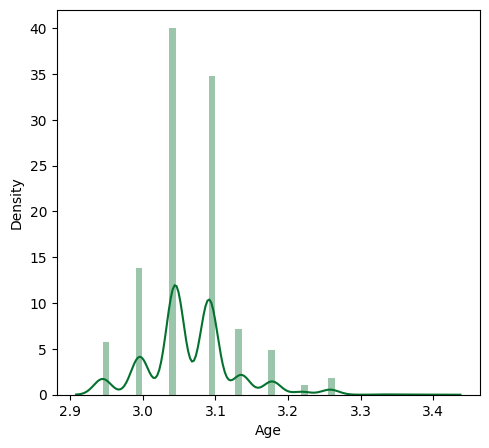

In [ ]:
def transformationplot(feature):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.distplot(feature)

transformationplot(np.log(df['Age']))

<ipython-input-60-c0a52fd22336>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(feature)


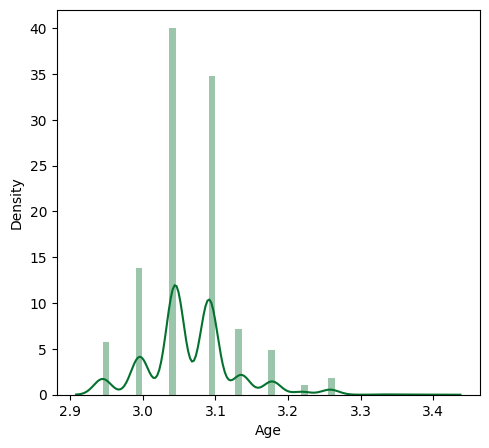

In [ ]:
def transformationplot(feature):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.distplot(feature)

transformationplot(np.log(df['Age']))

In [ ]:
# we are dropping the 'Hostel' column as it won't have much effect on our final output
df = df.drop(['Hostel'], axis=1)

In [ ]:
df

,Age,Gender,Stream,Internships,CGPA,HistoryOfBacklogs,PlacedOrNot
0,22,0,2,1,8,1,1
1,21,1,0,0,7,1,1
2,22,1,1,1,6,0,1
3,21,0,1,0,8,1,1
4,22,0,3,0,8,0,1
...,...,...,...,...,...,...,...
2961,23,0,1,0,7,0,0
2962,23,0,3,1,7,0,0
2963,22,0,1,1,7,0,0
2964,22,0,0,1,7,0,0


Assigning the 'independent' and 'dependent' variables

In [ ]:
X = df.drop(columns = 'PlacedOrNot', axis=1)
Y = df['PlacedOrNot']

In [ ]:
import joblib
joblib.dump(X,"placement")

['placement']

In [ ]:
print(X)

      Age  Gender  Stream  Internships  CGPA  HistoryOfBacklogs
0      22       0       2            1     8                  1
1      21       1       0            0     7                  1
2      22       1       1            1     6                  0
3      21       0       1            0     8                  1
4      22       0       3            0     8                  0
...   ...     ...     ...          ...   ...                ...
2961   23       0       1            0     7                  0
2962   23       0       3            1     7                  0
2963   22       0       1            1     7                  0
2964   22       0       0            1     7                  0
2965   23       0       5            0     8                  0

[2966 rows x 6 columns]


In [ ]:
print(Y)

0       1
1       1
2       1
3       1
4       1
       ..
2961    0
2962    0
2963    0
2964    0
2965    1
Name: PlacedOrNot, Length: 2966, dtype: int64


Scaling the data

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(X)

StandardScaler()

In [ ]:
standardized_data = scaler.transform(X)

In [ ]:
print(standardized_data)

[[ 0.38813058 -0.44540301  0.04008175  0.40044544  0.95719068  2.05024603]
 [-0.36675158  2.24515772 -1.14874288 -0.95077319 -0.07631043  2.05024603]
 [ 0.38813058  2.24515772 -0.55433057  0.40044544 -1.10981154 -0.48774634]
 ...
 [ 0.38813058 -0.44540301 -0.55433057  0.40044544 -0.07631043 -0.48774634]
 [ 0.38813058 -0.44540301 -1.14874288  0.40044544 -0.07631043 -0.48774634]
 [ 1.14301273 -0.44540301  1.82331869 -0.95077319  0.95719068 -0.48774634]]


In [ ]:
X = standardized_data
Y = df['PlacedOrNot']

Splitting the data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, stratify=Y, random_state=3)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(2966, 6) (2076, 6) (890, 6)


# Model building

Model 1(Support vector machine classifier)

In [ ]:
classifier = svm.SVC(kernel='linear')

In [ ]:
classifier.fit(X_train, Y_train)

SVC(kernel='linear')

In [ ]:
#testing accuracy
X_test_prediction = classifier.predict(X_test)
y_pred= accuracy_score(X_test_prediction, Y_test)
y_pred

0.751685393258427

In [ ]:
X_test

array([[ 1.14301273, -0.44540301,  0.04008175, -0.95077319,  0.95719068,
        -0.48774634],
       [-0.36675158, -0.44540301,  1.22890638, -0.95077319,  0.95719068,
        -0.48774634],
       [-0.36675158, -0.44540301,  0.63449406, -0.95077319, -1.10981154,
        -0.48774634],
       ...,
       [-0.36675158,  2.24515772, -0.55433057,  0.40044544,  0.95719068,
        -0.48774634],
       [ 1.14301273, -0.44540301,  0.04008175,  0.40044544, -1.10981154,
         2.05024603],
       [-0.36675158,  2.24515772,  0.04008175,  3.10288271, -1.10981154,
        -0.48774634]])

In [ ]:
#training accuracy
X_train_prediction = classifier.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [ ]:
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.7808285163776493


Model 2(KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [ ]:
best_k = {"Regular":0}
best_score = {"Regular":0}
for k in range(3, 50, 2):

    ## Using Regular training set
    knn_temp = KNeighborsClassifier(n_neighbors=k)              # Instantiate the model
    knn_temp.fit(X_train, Y_train)                              # Fit the model to the training set
    knn_temp_pred = knn_temp.predict(X_test)                    # Predict on the test set
    score = metrics.accuracy_score(Y_test, knn_temp_pred) * 100 # Get accuracy
    if score >= best_score["Regular"] and score < 100:          # Store best params
        best_score["Regular"] = score
        best_k["Regular"] = k


In [ ]:
print("---Results---\nK: {}\nScore: {}".format(best_k, best_score))
## Instantiate the models
knn = KNeighborsClassifier(n_neighbors=best_k["Regular"])
## Fit the model to the training set
knn.fit(X_train, Y_train)
knn_pred = knn.predict(X_test)
testd = accuracy_score(knn_pred, Y_test)

---Results---
K: {'Regular': 7}
Score: {'Regular': 86.85393258426967}


In [ ]:
knn_pred

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,

In [ ]:
print('Accuracy score of the test data using KNN : ', testd)

Accuracy score of the test data using KNN :  0.8685393258426967


In [ ]:
#checking the train accuracy
knn_pred_1 = knn.predict(X_train)
traind = accuracy_score(knn_pred_1, Y_train)
traind

0.8834296724470135

In [ ]:
knn_pred_1

array([1, 0, 0, ..., 0, 1, 0])

Model 3(ANN)

In [ ]:
X_train.shape

(2076, 6)

In [ ]:
Y_train.shape

(2076,)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers


In [ ]:
classifier = Sequential()

#add input layer and first hidden layer
classifier.add(keras.layers.Dense(6,activation = 'relu', input_dim = 6))
classifier.add(keras.layers.Dropout(0.50))
#add 2nd hidden layer
classifier.add(keras.layers.Dense(6,activation = 'relu'))
classifier.add(keras.layers.Dropout(0.50))

#final or output layer
classifier.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [ ]:
#Compiling the model

loss_1 = tf. keras.losses.BinaryCrossentropy()

classifier.compile(optimizer = 'Adam', loss = loss_1 , metrics = ['accuracy'])

In [ ]:
#fitting the model
classifier.fit(X_train, Y_train, batch_size = 20, epochs = 100)

Epoch 1/100
104/104 [==============================] - 4s 3ms/step - loss: 0.7586 - accuracy: 0.5058
Epoch 2/100
104/104 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5039
Epoch 3/100
104/104 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5607
Epoch 4/100
104/104 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6021
Epoch 5/100
104/104 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6146
Epoch 6/100
104/104 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6291
Epoch 7/100
104/104 [==============================] - 0s 2ms/step - loss: 0.6303 - accuracy: 0.6493
Epoch 8/100
104/104 [==============================] - 0s 2ms/step - loss: 0.6069 - accuracy: 0.6599
Epoch 9/100
104/104 [==============================] - 0s 2ms/step - loss: 0.5945 - accuracy: 0.6691
Epoch 10/100
104/104 [==============================] - 0s 2ms/step - loss: 0.5816 - accura

In [ ]:
# With the model fitted, we test the model on test data. Use a threshold of 0.5, to turn data into True(Placed) and False(NotPlaced) data.
pred = classifier.predict(X_test)
pred = (pred > 0.5)
pred

28/28 [==============================] - 0s 3ms/step


array([[ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
cm

saving and downloading the model

In [ ]:
import pickle

pickle.dump(knn,open("placement.pkl",'wb'))
model = pickle.load(open('placement.pkl', 'rb'))

In [ ]:
#input_data = (0.0,60.0,0.0,11.0,67349.0,0.0,0.0,0.0,1.0,3.0,44.0.1,14230.0,11.0,1.0,4461.0,2.0,0.0,3.0,0.0,18.0,1.0)
input_data = [[22,0,2,1,8,1]]

'''# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

# standardize the input data
std_data = scaler.transform(input_data_reshaped)
print(std_data)'''

prediction = knn.predict(input_data)
print(prediction)

if (prediction[0] == 0):
  print(' not placed')
else:
  print('placed')

[1]
placed
